In [1]:
import pandas as pd
import numpy as np
import glob, matplotlib
import matplotlib.backends.backend_pdf as pdf
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import cartopy.crs as ccrs

# Watermark is not required for this code, but is included for information. 
import watermark
%load_ext watermark
%watermark -a "ELEANOR LUTZ" -d -v -iv -m

numpy                           1.15.4
watermark                       1.8.1
matplotlib                      3.0.3
cartopy                         0.17.0
pandas                          0.23.4
matplotlib.backends.backend_pdf 3.0.3
ELEANOR LUTZ 2019-06-16 

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores  : 12
interpreter: 64bit


In [2]:
def set_save_image(fig, savename, show=False):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['image.composite_image'] = False

    # Remove borders on the plot axes
    for ax in fig.get_axes():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Remove all padding and margins
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(matplotlib.pyplot.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.pyplot.NullLocator())

    if savename.split('.')[-1] == 'pdf':
        pp = pdf.PdfPages(savename, keep_empty=False)
        pp.savefig(fig)
        pp.close()
    elif savename.split('.')[-1] == 'png':
        plt.savefig(savename, format='png', dpi=1200, pad_inches=0, transparent=True)
    else:
        print("Unrecognized file format, plot not saved!")
    
    if show == True: 
        plt.show()
    plt.clf()
    plt.close('all')

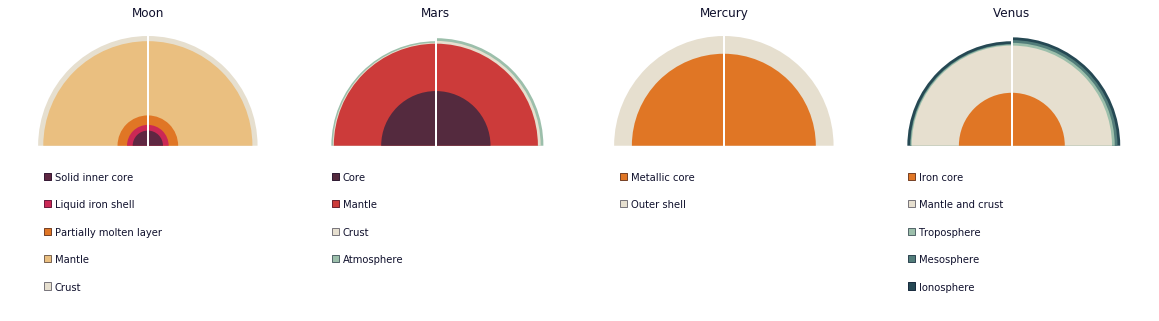

In [3]:
# Make comparison plot to show difference between adjusted widths and real data

savename = './figures/explanation.pdf'
df = pd.read_csv('./data/core_sources.csv')
df.dropna(subset=['color'], inplace=True)
min_r = 0.025

fig = plt.figure(figsize=(20, 4))
for i, obj in enumerate(df['object'].unique()):
    # Plot true values on left hand side of figure
    temp = df[df['object'] == obj].copy()
    total_radius = temp['km_from_previous'].astype(float).sum()
    
    ax = fig.add_subplot(1, 5, i+1, aspect='equal')
    temp.sort_values(by='depth_order', inplace=True)
    width = 0
    for index, row in temp.iterrows():
        curr_width = float(row['km_from_previous'])
        width += curr_width
        ax.add_patch(pch.Wedge((0,0), r=width, theta1=90, theta2=180,
                     zorder=len(temp)-row['depth_order'], 
                     facecolor=row['color'], edgecolor=None, lw=0))
        
    # Plot adjusted graphs on right hand side of figure
    num_too_small = len(temp[temp['km_from_previous'] < total_radius*min_r])
    if num_too_small > 0:
        total_radius += num_too_small*total_radius*min_r
    width = 0
    for index, row in temp.iterrows():
        curr_width = float(row['km_from_previous'])
        if curr_width < total_radius*min_r:
            curr_width = total_radius*min_r 
        width += curr_width
        ax.add_patch(pch.Wedge((0,0), r=width, theta1=0, theta2=90,
                     zorder=len(temp)-row['depth_order'], 
                     facecolor=row['color'], edgecolor=None, lw=0))
        h = (-row['depth_order']-1.25)*total_radius/df['depth_order'].max()
        bit = 15
        ax.text(-0.85*total_radius, h, row['name'].capitalize(), zorder=1000, color='#10112d')
        ax.add_patch(pch.Rectangle((-0.95*total_radius, h), total_radius/bit, total_radius/bit, 
                                   zorder=1000, color=row['color']))
        ax.add_patch(pch.Rectangle((-0.95*total_radius, h), total_radius/bit, total_radius/bit, 
                                   zorder=1000, edgecolor='#10112d', facecolor='None', alpha=0.5))

    ax.set_xlim(-total_radius*1.25, total_radius*1.25)
    ax.set_ylim(-total_radius*1.5, total_radius*1.125)
    ax.set_title(obj.capitalize(), color='#10112d')
    ax.plot([0, 0], [-total_radius, total_radius], lw=2, color='#ffffff', zorder = 1000)

set_save_image(fig, savename, show=True)

In [4]:
# Make high resolution images of each core diagram in a separate file
# using the adjusted visualization (all layers have a minimum thickness)

df = pd.read_csv('./data/core_sources.csv')
df.dropna(subset=['color'], inplace=True)
min_r = 0.025

for i, obj in enumerate(df['object'].unique()):
    savename = './figures/'+obj+'_core.pdf'
    temp = df[df['object'] == obj].copy()
    total_radius = temp['km_from_previous'].astype(float).sum()
    num_too_small = len(temp[temp['km_from_previous'] < total_radius*min_r])
    if num_too_small > 0:
        total_radius += num_too_small*total_radius*min_r
    
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, aspect='equal')
    temp.sort_values(by='depth_order', inplace=True)
    width = 0
    for index, row in temp.iterrows():
        curr_width = float(row['km_from_previous'])
        if curr_width < total_radius*min_r:
            curr_width = total_radius*min_r 
        width += curr_width
        ax.add_patch(pch.Wedge((0,0), r=width, theta1=-90, theta2=90,
                     zorder=len(temp)-row['depth_order'], 
                     facecolor=row['color'], edgecolor=None, lw=0))

    ax.set_xlim(-total_radius, total_radius)
    ax.set_ylim(-total_radius, total_radius)
    set_save_image(fig, savename, show=False)

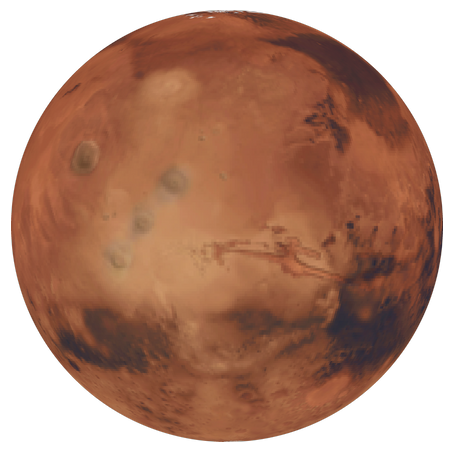

In [5]:
# Take Plate Carree projection of surfaces and reproject to a sphere (orthographic)
# Images are taken from the Stellarium github repository for convenience:
# https://github.com/Stellarium/stellarium/tree/master/textures
# But are also available in the Public Commons from NASA sources

objects = ['moon', 'mars', 'mercury', 'venus']

for obj in objects:
    readname = glob.glob('./data/surface_images/'+obj+'*')[0]
    savename = './figures/'+obj+'_surface.png'

    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection=ccrs.Orthographic(270, 0))
    img = plt.imread(readname)
    ax.imshow(img, origin='upper', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree(), 
              interpolation='spline36', regrid_shape=4000)

    ax.set_global()
    ax.outline_patch.set_edgecolor('none')
    
    if obj == 'mars':
        show = True
    else:
        show = False
    set_save_image(fig, savename, show=show)